# 1. Predicting Gender of Brazilian Names Using Deep Learning


## 1.1 Necessary libraries

In [ ]:
import pandas as pd                       
import numpy as np
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, GRU, SimpleRNN, LSTM, Bidirectional, Activation, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt


## 1.2 Download the dataset

In [ ]:
import requests
url = "https://data.brasil.io/dataset/genero-nomes/nomes.csv.gz"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

df = pd.read_csv('nomes.csv.gz') 
df.head()

,alternative_names,classification,first_name,frequency_female,frequency_male,frequency_total,frequency_group,group_name,ratio
0,AILINE|ALEINE|ALIINE|ALINE|ALINER|ALINHE|ALINN...,F,AALINE,66.0,NaN,66,530550,ALINE,1.0
1,ARAAO|ARAO,M,AARAO,NaN,281.0,281,3526,ARAO,1.0
2,AHARON|AROM|ARON|ARYON|HARON,M,AARON,NaN,676.0,676,3442,ARON,1.0
3,ADA|ADAH|ADAR|ADHA|HADA,F,ABA,82.0,NaN,82,5583,ADA,1.0
4,NaN,M,ABADE,NaN,57.0,57,57,ABADE,1.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100787 entries, 0 to 100786
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   alternative_names  70745 non-null   object 
 1   classification     100787 non-null  object 
 2   first_name         100787 non-null  object 
 3   frequency_female   60484 non-null   float64
 4   frequency_male     50932 non-null   float64
 5   frequency_total    100787 non-null  int64  
 6   frequency_group    100787 non-null  int64  
 7   group_name         100787 non-null  object 
 8   ratio              100787 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.9+ MB


### 1.2.1 Preparing the data 

In [ ]:
y = df['classification'].astype("category").cat.codes.values    # y labels into numbers 0 is F and 1 is M
names = df['first_name'].apply(lambda x: x.lower())             # input names

In [ ]:
print("M : " + str(sum(y==1)))
print("F : " + str(sum(y==0)))
print(len(y))

M : 45537
F : 55250
100787


## 1.3 Encoding Words

Neural networks can only learn to find patterns in numerical data, so it is necessary to convert our data into numeric values with word encoding or tokenization. 

In [ ]:
#word encoding
maxlen = 20                                               # max lenght of a name
'''Define a vocabulary which corresponds to all the unique letters encountered'''
vocab = set(' '.join([str(i) for i in names]))            # creating a vocab
vocab.add('END')
len_vocab = len(vocab)
''' The dictionary maps each letter of vocabulary to a number '''
char_index = dict((c, i) for i, c in enumerate(vocab))    # creating a dictionary

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    aux = np.zeros(len_vocab);
    aux[i] = 1
    return list(aux)

# Truncate names and create the matrix
def prepare_encod_names(X):
    vec_names = []
    trunc_name = [str(i)[0:maxlen] for i in X]  # consider only the first 20 characters
    for i in trunc_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        vec_names.append(tmp)
    return vec_names

In [ ]:
x = prepare_encod_names(names.values)   # Now the names are encod as a vector of numbers 

## 1.4 Split the data into test and train

In [ ]:
# train, val, test set will be 60%, 20%, 20% of the dataset respectively
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=28)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=40)
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

## 1.5 Building the CNN Model

In [ ]:
CNNmodel = keras.Sequential()  
CNNmodel.add(Conv1D(32, 2, activation='relu', input_shape=(20,28) )) # 32 convolution filters used each of size 2
CNNmodel.add(Conv1D(64, 3, activation='relu' ))       # 64 convolution filters used each of size 3
CNNmodel.add(MaxPooling1D(pool_size=(1,)))            # choose the best features via pooling
CNNmodel.add(Dropout(0.25))                           # randomly turn neurons on and off to improve convergence
CNNmodel.add(Flatten())                               # flatten we only want a classification output
CNNmodel.add(Dense(150, activation='relu'))           # fully connected to get all relevant data
CNNmodel.add(Dropout(0.1))                            # one more dropout
CNNmodel.add(Dense(1, activation='sigmoid'))          # output 

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adagrad(learning_rate=lr_schedule)
CNNmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

CNNhistory = CNNmodel.fit(x_train, y_train, validation_data=(x_val, y_val),  epochs=20, batch_size=128) # Getting score metrics
scores = CNNmodel.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/20
473/473 [==============================] - 8s 14ms/step - loss: 0.6498 - accuracy: 0.6152 - val_loss: 0.5025 - val_accuracy: 0.8038
Epoch 2/20
473/473 [==============================] - 7s 14ms/step - loss: 0.3809 - accuracy: 0.8295 - val_loss: 0.3112 - val_accuracy: 0.8622
Epoch 3/20
473/473 [==============================] - 7s 14ms/step - loss: 0.3077 - accuracy: 0.8627 - val_loss: 0.2835 - val_accuracy: 0.8762
Epoch 4/20
473/473 [==============================] - 7s 14ms/step - loss: 0.2816 - accuracy: 0.8764 - val_loss: 0.2649 - val_accuracy: 0.8861
Epoch 5/20
473/473 [==============================] - 7s 14ms/step - loss: 0.2644 - accuracy: 0.8860 - val_loss: 0.2613 - val_accuracy: 0.8873
Epoch 6/20
473/473 [==============================] - 7s 14ms/step - loss: 0.2521 - accuracy: 0.8921 - val_loss: 0.2422 - val_accuracy: 0.9004
Epoch 7/20
473/473 [==============================] - 7s 14ms/step - loss: 0.2438 - accuracy: 0.8977 - val_loss: 0.2339 - val_accuracy: 0.9056

## 1.6 Building the RNN Model

In [ ]:
RNNmodel=keras.Sequential()
RNNmodel.add(SimpleRNN(32, input_shape=(x_train.shape[1],x_train.shape[2]), activation='tanh', return_sequences=True))
RNNmodel.add(TimeDistributed(Dense(1))) 
RNNmodel.add(Flatten())
RNNmodel.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
RNNmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

RNNhistory=RNNmodel.fit(x_train, y_train , epochs=20, batch_size=128, validation_data=(x_val,y_val))
RNNscores = RNNmodel.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (RNNscores[1]*100))

Epoch 1/20
473/473 [==============================] - 4s 7ms/step - loss: 0.2621 - accuracy: 0.8881 - val_loss: 0.2249 - val_accuracy: 0.9079
Epoch 2/20
473/473 [==============================] - 3s 7ms/step - loss: 0.2004 - accuracy: 0.9211 - val_loss: 0.2086 - val_accuracy: 0.9143
Epoch 3/20
473/473 [==============================] - 3s 7ms/step - loss: 0.1884 - accuracy: 0.9252 - val_loss: 0.2016 - val_accuracy: 0.9238
Epoch 4/20
473/473 [==============================] - 3s 7ms/step - loss: 0.1810 - accuracy: 0.9280 - val_loss: 0.1844 - val_accuracy: 0.9276
Epoch 5/20
473/473 [==============================] - 3s 7ms/step - loss: 0.1724 - accuracy: 0.9329 - val_loss: 0.1796 - val_accuracy: 0.9308
Epoch 6/20
473/473 [==============================] - 3s 7ms/step - loss: 0.1685 - accuracy: 0.9356 - val_loss: 0.1761 - val_accuracy: 0.9325
Epoch 7/20
473/473 [==============================] - 3s 7ms/step - loss: 0.1648 - accuracy: 0.9366 - val_loss: 0.1881 - val_accuracy: 0.9263
Epoch 

## 1.7 Building the GRU Model

In [ ]:
GRUmodel=keras.Sequential()
GRUmodel.add(GRU(32, input_shape=(x_train.shape[1],x_train.shape[2]),activation='tanh', return_sequences=True))
GRUmodel.add(TimeDistributed(Dense(1))) 
GRUmodel.add(Flatten())
GRUmodel.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
GRUmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

GRUhistory=GRUmodel.fit(x_train, y_train , epochs=20, batch_size=128, validation_data=(x_val,y_val))
GRUscores = GRUmodel.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (GRUscores[1]*100))  

Epoch 1/20
473/473 [==============================] - 8s 14ms/step - loss: 0.2617 - accuracy: 0.8849 - val_loss: 0.2117 - val_accuracy: 0.9167
Epoch 2/20
473/473 [==============================] - 6s 13ms/step - loss: 0.1729 - accuracy: 0.9322 - val_loss: 0.1674 - val_accuracy: 0.9355
Epoch 3/20
473/473 [==============================] - 6s 13ms/step - loss: 0.1521 - accuracy: 0.9412 - val_loss: 0.1689 - val_accuracy: 0.9323
Epoch 4/20
473/473 [==============================] - 6s 13ms/step - loss: 0.1394 - accuracy: 0.9467 - val_loss: 0.1481 - val_accuracy: 0.9439
Epoch 5/20
473/473 [==============================] - 6s 13ms/step - loss: 0.1299 - accuracy: 0.9505 - val_loss: 0.1481 - val_accuracy: 0.9428
Epoch 6/20
473/473 [==============================] - 6s 13ms/step - loss: 0.1201 - accuracy: 0.9544 - val_loss: 0.1393 - val_accuracy: 0.9469
Epoch 7/20
473/473 [==============================] - 6s 13ms/step - loss: 0.1147 - accuracy: 0.9558 - val_loss: 0.1478 - val_accuracy: 0.9430

## 1.8 Building the DNN Model

In [ ]:
DNNmodel = keras.Sequential()                                   # Sequential model
n_inputs = 28                                                   # nº of states  
inputs = keras.Input(shape=(20,n_inputs,), name = 'input')      # Define inputs
l1=layers.Dense(64, activation='relu', name = 'hidden_layer_1')(inputs) 
ly2=layers.Dense(128, activation='softplus', name = 'hidden_layer_2')(l1) 
l3=layers.Dropout(0.25)(ly2)
l4=layers.Flatten()(l3)                 
output=[] 
output.append(layers.Dense(1, activation='sigmoid', name = 'output')(l4))                                    
DNNmodel = keras.Model(inputs=inputs, outputs=output)       

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
DNNmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

DNNhistory = DNNmodel.fit(x_train, y_train, batch_size=32, epochs=20, validation_data =(x_val, y_val))
DNNscores = DNNmodel.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (DNNscores[1]*100))

Epoch 1/20
1890/1890 [==============================] - 11s 6ms/step - loss: 0.3831 - accuracy: 0.8315 - val_loss: 0.3311 - val_accuracy: 0.8518
Epoch 2/20
1890/1890 [==============================] - 11s 6ms/step - loss: 0.3360 - accuracy: 0.8519 - val_loss: 0.3265 - val_accuracy: 0.8615
Epoch 3/20
1890/1890 [==============================] - 11s 6ms/step - loss: 0.3284 - accuracy: 0.8564 - val_loss: 0.3343 - val_accuracy: 0.8570
Epoch 4/20
1890/1890 [==============================] - 11s 6ms/step - loss: 0.3271 - accuracy: 0.8552 - val_loss: 0.3125 - val_accuracy: 0.8626
Epoch 5/20
1890/1890 [==============================] - 11s 6ms/step - loss: 0.3236 - accuracy: 0.8580 - val_loss: 0.3164 - val_accuracy: 0.8609
Epoch 6/20
1890/1890 [==============================] - 11s 6ms/step - loss: 0.3227 - accuracy: 0.8589 - val_loss: 0.3134 - val_accuracy: 0.8656
Epoch 7/20
1890/1890 [==============================] - 11s 6ms/step - loss: 0.3216 - accuracy: 0.8582 - val_loss: 0.3145 - val_ac

## 1.9 Building the BiLSTM Model

In [ ]:
LSTMmodel = keras.Sequential()
LSTMmodel.add(Bidirectional(LSTM(64, return_sequences=True), backward_layer=LSTM(64, return_sequences=True, go_backwards=True), input_shape=(maxlen,len_vocab)))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Bidirectional(LSTM(64)))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Dense(1, activity_regularizer=l2(0.002)))
LSTMmodel.add(Activation('sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
LSTMmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

LSTMhistory = LSTMmodel.fit(x_train, y_train, batch_size=128, epochs=20, validation_data =(x_val, y_val))
LSTMscores = LSTMmodel.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (LSTMscores[1]*100))

Epoch 1/20
473/473 [==============================] - 56s 104ms/step - loss: 0.2607 - accuracy: 0.8879 - val_loss: 0.1912 - val_accuracy: 0.9259
Epoch 2/20
473/473 [==============================] - 48s 102ms/step - loss: 0.1702 - accuracy: 0.9354 - val_loss: 0.1578 - val_accuracy: 0.9390
Epoch 3/20
473/473 [==============================] - 48s 102ms/step - loss: 0.1461 - accuracy: 0.9450 - val_loss: 0.1444 - val_accuracy: 0.9451
Epoch 4/20
473/473 [==============================] - 48s 101ms/step - loss: 0.1275 - accuracy: 0.9520 - val_loss: 0.1321 - val_accuracy: 0.9500
Epoch 5/20
473/473 [==============================] - 48s 101ms/step - loss: 0.1137 - accuracy: 0.9579 - val_loss: 0.1261 - val_accuracy: 0.9526
Epoch 6/20
473/473 [==============================] - 48s 101ms/step - loss: 0.1006 - accuracy: 0.9617 - val_loss: 0.1199 - val_accuracy: 0.9547
Epoch 7/20
473/473 [==============================] - 48s 102ms/step - loss: 0.0917 - accuracy: 0.9650 - val_loss: 0.1171 - val_ac

## 1.10 Figures

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

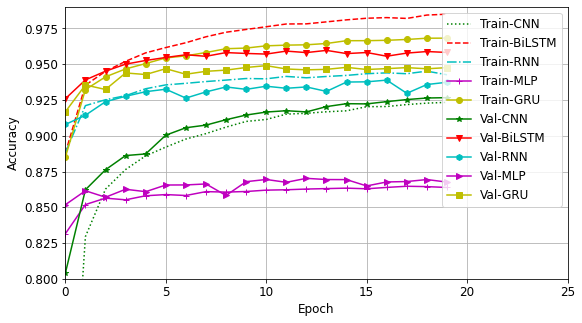

In [ ]:
plt.figure(1)
plt.figure(figsize=(9,5))
plt.rcParams.update({'font.size': 12})
# summarize for accuracy
plt.plot(CNNhistory.history['accuracy'], 'g:')
plt.plot(LSTMhistory.history['accuracy'], 'r--')
plt.plot(RNNhistory.history['accuracy'], 'c-.')
plt.plot(DNNhistory.history['accuracy'], 'm-+')
plt.plot(GRUhistory.history['accuracy'], 'y-o')
plt.plot(CNNhistory.history['val_accuracy'], 'g-*')
plt.plot(LSTMhistory.history['val_accuracy'], 'r-v')
plt.plot(RNNhistory.history['val_accuracy'], 'c-h')
plt.plot(DNNhistory.history['val_accuracy'], 'm->')
plt.plot(GRUhistory.history['val_accuracy'], 'y-s')
plt.grid('True')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.8, 0.99)
plt.xlim(0,25)
plt.legend(['Train-CNN', 'Train-BiLSTM', 'Train-RNN', 'Train-MLP', 'Train-GRU','Val-CNN',\
            'Val-BiLSTM', 'Val-RNN', 'Val-MLP', 'Val-GRU'], loc='upper right')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


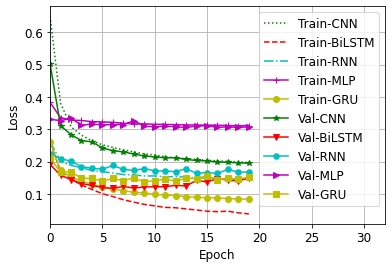

In [ ]:
plt.figure(2)
plt.plot(CNNhistory.history['loss'], 'g:')
plt.plot(LSTMhistory.history['loss'], 'r--')
plt.plot(RNNhistory.history['loss'], 'c-.')
plt.plot(DNNhistory.history['loss'], 'm-+')
plt.plot(GRUhistory.history['loss'], 'y-o')
plt.plot(CNNhistory.history['val_loss'], 'g-*')
plt.plot(LSTMhistory.history['val_loss'], 'r-v')
plt.plot(RNNhistory.history['val_loss'], 'c-H')
plt.plot(DNNhistory.history['val_loss'], 'm->')
plt.plot(GRUhistory.history['val_loss'], 'y-s')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train-CNN', 'Train-BiLSTM', 'Train-RNN', 'Train-MLP', 'Train-GRU','Val-CNN',\
            'Val-BiLSTM', 'Val-RNN', 'Val-MLP', 'Val-GRU'], loc='upper right')
plt.grid('True')
plt.xlim(0,32)

## 1.11 Statistics

In [ ]:
y_predCNN =(CNNmodel.predict(x_test) > 0.5).astype("int32")
y_predLSTM =(LSTMmodel.predict(x_test) > 0.5).astype("int32")
y_predRNN =(RNNmodel.predict(x_test) > 0.5).astype("int32")
y_predGRU =(GRUmodel.predict(x_test) > 0.5).astype("int32")
y_predDNN =(DNNmodel.predict(x_test) > 0.5).astype("int32")

In [ ]:
# Finding precision and recall
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_test, y_predLSTM))
print(recall_score(y_test, y_predLSTM))

print(precision_score(y_test, y_predRNN))
print(recall_score(y_test, y_predRNN))

print(precision_score(y_test, y_predCNN))
print(recall_score(y_test, y_predCNN))

print(precision_score(y_test, y_predGRU))
print(recall_score(y_test, y_predGRU))

print(precision_score(y_test, y_predDNN))
print(recall_score(y_test, y_predDNN))

0.9556216275740557
0.9532073813708261
0.9268345636126791
0.937829525483304
0.9169035643997376
0.9211335676625659
0.9507609668755596
0.9332161687170475
0.8860109811410838
0.8153558875219684


## 1.12 Testing 

In [ ]:
testename = prepare_encod_names({"cibely"})   # Now the names are encod as a vector of numbers with weight
resu=(LSTMmodel.predict(testename) > 0.5).astype("int32")
if int(resu)==1:
  print('M')
else:
  print('F')

F
